# OPTIMIZATION FOR LARGE-SCALE DATA

Social platform optimization

Student: Francisco Esteves Muñoz

Date: 09/12/2022

a) Formulate mathematically the problem as a linear optimization model
(based on the general formulation of an LP). Identify the model sets, parameters,variables, objective function and constraints.

# <font color="red"> Problem formulation</font>

"The Tree" social network, is a widely used platform for sharing short videos of regular people doing funny things. It uses a very powerfull algorithm which selects the most popular video for every personality trade.

However, it finances are not very stable, as no time has been dedicated to publicity optimization. Publicity represents almost all the revenues that the company has.

In this assignment, it will be fomulated, one way of selecting the publicity for "The Tree".

<li> <font color="blue">Personality trades:</font>

The company has well classified every user of the platform in 10 categories. Each category has a number associated to it which represent how many users in the platform are identified as that trade:

$$q_{k}: \textrm{number of people belonging to k client category}$$

<li> <font color="blue">Publicity:</font>:

There are 10 types of publicities (non-related with the 10 types of personality). For every type of personality, 30 companies present their publicity. Each publicity has assignated some value, which represent the value of being showed to a client between videos.

$x_{kij}: \textrm{times to be show weekly, to the personality k, the publicity of company j and type i} $
$s_{kij}: \textrm{price to show the publicity $x_{kij}$ one time to a client}$

So, the optimization problem objective could be seen as:

$$\max \sum\limits_{i,j,k} p_{kij} x_{kij} q_{k}$$


<li> <font color="blue">Constraints:</font>:

All the variables are non-negative:

$$x_{kij} \geq\ 0$$

Also, there is a maximum amount of money every company is willing to pay per week:

$$\sum\limits_{j} x_{kij}p_{kij}q_{k}\leq\ S_{j}\ \forall j\$$

Maximum publicity that a tpye of client (depends on the personality trade) can stand without getting annoyed:

$$\sum\limits_{k} x_{kij}\leq\ N_{k}\ \forall k\$$

The same publicity will not be shown more than two times a day (this is a weekly algorithm):
$$x_{kij}\leq\ 14\ \forall k,i,j\$$

b) Implement the model in Pyomo and solve it for a set of (parameter) values,
either based on real-world or randomly generated data (make sure that the values you use are coherent with the model defined in a). In both cases, include your model and the specific data you have used.

In [ ]:
!pip install -q pyomo
!apt-get install -y -qq glpk-utils

     |████████████████████████████████| 11.1 MB 5.2 MB/s 
     |████████████████████████████████| 49 kB 4.4 MB/s 
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 124013 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_4.65-1_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_4.65-1_amd64.deb ...
Unpacking glpk-utils (4.65-1) ...
Setting up

In [ ]:
##Inizialization
import pyomo.environ as pyo
import sys
from pyomo.opt import SolverFactory

opt = pyo.SolverFactory('glpk')
model = pyo.ConcreteModel(name="the_tree")

In [ ]:
##Setting the data matrices
import numpy as np
import random

np.random.seed(42)
K = 10                                                                          #Number of personalities
m = 10                                                                          #Number of tpyes of publicities
n = 30                                                                          #Number of companies interested in publicity

xp = np.random.normal(loc=0.05, scale = 0.025, size=K*m*n)                      #Random generated data from a Gaussian
p={}                                                                            #Price for publicity at every k,i,j
w=0
for k in range(K):
  for i in range(m):
    for j in range(n):
      p[(k+1,i+1,j+1)] = xp[w]
      if p[(k+1,i+1,j+1)]<0:
        p[(k+1,i+1,j+1)] = 0
      w+=1

xq = np.random.normal(loc=15000000, scale = 3000000, size = K)                  #Random generated data from a Gaussian
q={}                                                                            #Number of people belonging to each cluster
for k in range(K):
  q[k+1] = int(xq[k])

xs = np.random.normal(loc=20000000,scale=500000,size = n)                       #Random generated data from a Gaussian
S={}
for j in range(n):
  S[j+1]=max(0,xs[j])

N={}                                                                            #Maximum publicity for every people belonging to each cluster (per-week)
xn = np.random.normal(loc=30,scale=20,size=K)                                   #Random generated data from a Gaussian
for i in range(K):
  N[i+1] = max(7,int(xn[i]))


In [ ]:
#Initialize the variables in pyomo environment
model.k = pyo.Param(within=pyo.NonNegativeIntegers,initialize=K)
model.m = pyo.Param(within=pyo.NonNegativeIntegers,initialize=m)
model.n = pyo.Param(within=pyo.NonNegativeIntegers,initialize=n)

#Initialize the rages(1,variable) in the pyomo environment
model.K = pyo.RangeSet(1,model.k)                                               #Number of personalities
model.I = pyo.RangeSet(1,model.m)                                               #Number of tpyes of publicities
model.J = pyo.RangeSet(1,model.n)                                               #Number of companies interested in publicity

#Initialize parameters for contraints
model.P = pyo.Param(model.K,model.I, model.J,initialize=p)                      #Price for every publicity
model.S = pyo.Param(model.J,initialize=S)                                       #Maximum income recibed by every company
model.N = pyo.Param(model.K,initialize=N)                                       #Available money per company
model.Q = pyo.Param(model.K,initialize=q)

# Defining the variables x_k,i,j
model.X = pyo.Var(model.K,model.I,model.J, domain=pyo.NonNegativeReals)         #Decision variables are defined

In [ ]:
#Some prints to check the order of the parameters
print(q)
print(S)
print(p)
print(N)

{1: 9276577, 2: 12418844, 3: 13759183, 4: 20663062, 5: 16669659, 6: 10993555, 7: 16458108, 8: 10358088, 9: 18248073, 10: 13586626}
{1: 19953181.905630413, 2: 20662898.323771097, 3: 19356418.215707876, 4: 19301440.907443505, 5: 19708200.336827, 6: 20519189.425509658, 7: 19240326.96226158, 8: 18583922.200944714, 9: 19774420.5707955, 10: 20275870.39995546, 11: 20600130.874869414, 12: 19768419.3189573, 13: 19794286.696442, 14: 20576950.367127873, 15: 19065129.15015229, 16: 19805739.612408496, 17: 20095211.944962528, 18: 20224609.36064252, 19: 19745096.65340456, 20: 20017220.50585292, 21: 18755836.323293507, 22: 19670875.793833077, 23: 20226754.356277235, 24: 19508852.98287266, 25: 20029492.110794798, 26: 20223436.250401348, 27: 19828725.399571117, 28: 20085231.885498285, 29: 19518633.717357695, 30: 19896694.360151976}
{(1, 1, 1): 0.06241785382528082, (1, 1, 2): 0.04654339247072039, (1, 1, 3): 0.06619221345251732, (1, 1, 4): 0.08807574641020063, (1, 1, 5): 0.044146165631916603, (1, 1, 6): 0

In [ ]:
#Definition of the objective function
def obj_expression(model):
	return sum(model.P[k,i,j]*model.X[k,i,j]*model.Q[k] for i in model.I for j in model.J for k in model.K)

model.OBJ = pyo.Objective(rule=obj_expression,sense = pyo.maximize)

#Maximum amount of money that each company is willing to invest in publicity:
def S_constraint_rule(model, j):
     return sum(model.X[k,i,j]*model.P[k,i,j]*model.Q[k] for k in model.K for i in model.I )<= model.S[j]

model.S_Constraint = pyo.Constraint(model.J, rule=S_constraint_rule)

#Maximum publicity that is tolerated by every type of user:
def N_constraint_rule(model, k):
     return sum(model.X[k,i,j] for i in model.I for j in model.J)<= model.N[k]

model.N_Constraint = pyo.Constraint(model.K, rule=N_constraint_rule)

#Not show to much every publicity:
def T_constraint_rule(model,k,i,j):
     return model.X[k,i,j] <= 14

model.T_Constraint = pyo.Constraint(model.K,model.I,model.J, rule=T_constraint_rule)

results = opt.solve(model)                                                      #Solve the model

In [ ]:
model.display()                                                                 #Show decision variables, OF and constraints

Se han truncado las últimas 5000 líneas del flujo de salida.
           (4, 6, 4) :     0 :               0.0 :  None : False : False : NonNegativeReals
           (4, 6, 5) :     0 :               0.0 :  None : False : False : NonNegativeReals
           (4, 6, 6) :     0 :               0.0 :  None : False : False : NonNegativeReals
           (4, 6, 7) :     0 :               0.0 :  None : False : False : NonNegativeReals
           (4, 6, 8) :     0 :               0.0 :  None : False : False : NonNegativeReals
           (4, 6, 9) :     0 :               0.0 :  None : False : False : NonNegativeReals
          (4, 6, 10) :     0 :               0.0 :  None : False : False : NonNegativeReals
          (4, 6, 11) :     0 :               0.0 :  None : False : False : NonNegativeReals
          (4, 6, 12) :     0 :               0.0 :  None : False : False : NonNegativeReals
          (4, 6, 13) :     0 :               0.0 :  None : False : False : NonNegativeReals
          (4, 6, 14

In [ ]:
#Show only the variables that are different from zero
for v in model.component_objects(ctype=pyo.Var):
    for index in v:
      if pyo.value(v[index]) != 0:
        print('{0} = {1}'.format(v[index],pyo.value(v[index])))

#X[personality, type of adv., company]

X[1,4,24] = 14.0
X[1,6,30] = 0.816711885822433
X[1,7,30] = 14.0
X[1,8,11] = 13.1832881141776
X[2,1,24] = 3.94909195827179
X[2,5,1] = 10.6540095219109
X[2,6,11] = 6.0186210658998
X[2,6,29] = 12.3782774539176
X[3,6,6] = 12.8772513779648
X[3,6,13] = 5.12274862203519
X[4,1,10] = 6.75757433791035
X[4,7,23] = 9.57724991058857
X[4,8,7] = 8.45839739216427
X[4,9,18] = 9.20677835933682
X[5,2,4] = 10.113118397347
X[5,7,3] = 9.9387872656386
X[5,7,13] = 5.64093291024992
X[5,9,14] = 10.7299470045986
X[5,10,22] = 0.603100069214721
X[5,10,27] = 6.97411435295117
X[6,9,27] = 7.0
X[7,1,1] = 4.06265576280011
X[7,4,22] = 10.6406931164658
X[7,5,5] = 11.7570188483513
X[7,5,10] = 3.5260382077979
X[7,5,15] = 9.97689763432589
X[7,6,8] = 8.79112829682712
X[7,8,26] = 4.24556813343182
X[8,1,21] = 14.0
X[8,7,26] = 9.0
X[9,4,17] = 8.90040630758777
X[9,5,2] = 9.08545107216407
X[9,5,9] = 10.5125502113762
X[9,6,25] = 9.50159240887199
X[10,1,3] = 1.56823844407034
X[10,1,21] = 2.05395225814638
X[10,4,12] = 12.40128378142

Note that there are some variables with floating numbers as answer. This is phisically impossible, but as there are millions of people belonging to every cluster of personalities, the sollution will be to show the advertisment to a fraction of that particular cluster. Of course, many publicities will not be shown, as the market is allready full.

c) Compute the sensitivities associated with each constraint, and interpret the
values of those you may consider more important.

In [ ]:
#Sensitivity
model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
results_dual = opt.solve(model)

In [ ]:
dual_company = np.zeros(n)
#Sensitivity for the constrain of maximum money each company is willing to pay
for j in range(n):
  dual_company[j] = model.dual[model.S_Constraint[j+1]]
print('Money gained weekly if the company j spend one more EUR: \n\n', dual_company)

#Sensitivity for the constrain of maximum advesrises each customer can tolerate
dual_publ = np.zeros(m)
dual_people = np.zeros(m)
for k in range(K):
  dual_publ[k] = int(model.dual[model.N_Constraint[k+1]])
  dual_people[k] = dual_publ[k]/q[k+1]*model.N[k+1]
print('Money gained weekly if the personality k could seen one more advertisment: \n\n', dual_publ)
print('Money gained weekly if "The Tree" sum one costumer of personality k: \n\n', dual_people)

Money gained weekly if the company j spend one more EUR: 

 [0.0450197  0.18629231 0.03461879 0.12365896 0.08554623 0.01560699
 0.11014143 0.2748652  0.         0.05880919 0.02189077 0.17465529
 0.         0.12784363 0.19782842 0.34640311 0.1803463  0.07854762
 0.08187431 0.1220185  0.02043088 0.11952352 0.04157095 0.05240291
 0.12211097 0.21726337 0.01184693 0.         0.23645889 0.10592031]
Money gained weekly if the personality k could seen one more advertisment: 

 [ 978726. 1203986. 1568575. 2024162. 1672544. 1132756. 1532891. 1035736.
 1850602. 1315650.]
Money gained weekly if "The Tree" sum one costumer of personality k: 

 [4.43121337 3.19929439 2.05203681 3.3306539  4.41472354 0.72126732
 4.93636468 2.29983835 3.85371518 5.13221237]


For this problem it has been consider many alternatives to the sensitivity problem.

On one side, the sensitivity of the restriction for the maximum advertistment for every type of costumer has been calculated. For this restriction, the interpretation is the following: if the company j invest 1€ more in advertistment, how much that would increase our gains. For this particular example, "The Tree" would be very intreseted in the 16th company, that would increase 0.35€ for every additional 1€ (not very huge gain though).

The other analysis of sensitivity is less traditional, it studies what are the gains of forcing one more advertisment on every client with personality k. Of course this approach would be risky, as those maximum have been studied in order to assure that the costumer keep using the platform. But also, there is a posibility to sum one client of personality k (which is not really a restriction, but could direct some of the marketing campaigns of "The Tree"). The resutls of the latter analysis imply that the better personalities to focus on gaining users are 1st, 5th, 7th, 10th.


d) Modify the problem in a) to impose some logical or conditional (linear)
constraints that require the use of binary or integer variables. Implement and solve this new model in Pyomo and interpret the results. Include the data used for the
solution of the problem.

________________________________________________________________________________
The artificial modification that has been created is the competition of the companies. In this case, we have 30 companies and every company has many types of adverstisment. In this new situation, we have to choose between advertisment companies which are oposite to each other. That means that "The Tree" cannot have advertisment of two companies that offer similar products/services.

The 1st is opossite to 16th, 2nd opossite to 17th and so forth.

<li> <font color="blue"> New additional constraints:</font>:

Binary condition to select between company j and company j+[n/2]:

$$y_{j} + y_{j+[n/2]} \leq\ 1$$
$$y_{j} \in 0,1\ $$
$$j \in 1,2,...,[n/2]\ $$

Force the $x_{kij}$ to be zero if $y_{j}$ is zero:

$$\sum\limits_{k,i} x_{kij}\leq\ M y_{j}\ \forall j\$$
 $M$ → +$\infty$

In [ ]:
#Create other model for the binary problem
mod_binary = pyo.ConcreteModel(name="the_tree_binary")

#Initialize some variables
mod_binary.k = pyo.Param(within=pyo.NonNegativeIntegers,initialize=K)
mod_binary.m = pyo.Param(within=pyo.NonNegativeIntegers,initialize=m)
mod_binary.n = pyo.Param(within=pyo.NonNegativeIntegers,initialize=n)

#Initialize ranges
mod_binary.K = pyo.RangeSet(1,mod_binary.k)                                     #Number of personalities
mod_binary.I = pyo.RangeSet(1,mod_binary.m)                                     #Number of tpyes of publicities
mod_binary.J = pyo.RangeSet(1,mod_binary.n)                                     #Number of companies interested in publicity

#Initialize constraints parameters
mod_binary.P = pyo.Param(mod_binary.K,mod_binary.I, mod_binary.J,initialize=p)  #Price for every publicity
mod_binary.S = pyo.Param(mod_binary.J,initialize=S)                             #Maximum income recibed by every company
mod_binary.N = pyo.Param(mod_binary.K,initialize=N)                             #Available money per company
mod_binary.Q = pyo.Param(mod_binary.K,initialize=q)                             #Number of clients for every personality trade

# Defining the variables x_k,i,j
mod_binary.X = pyo.Var(mod_binary.K,mod_binary.I,mod_binary.J, domain=pyo.NonNegativeReals)

In [ ]:
#Same conditions as the original problem:

#Definition of the objective function
def obj_expression(mod_binary):
	return sum(mod_binary.P[k,i,j]*mod_binary.X[k,i,j]*mod_binary.Q[k] for i in mod_binary.I for j in mod_binary.J for k in mod_binary.K)

mod_binary.OBJ = pyo.Objective(rule=obj_expression,sense = pyo.maximize)

#Maximum amount of money that each company is willing to invest in publicity:
def S_constraint_rule(mod_binary, j):
     return sum(mod_binary.X[k,i,j]*mod_binary.P[k,i,j]*mod_binary.Q[k] for k in mod_binary.K for i in mod_binary.I )<= mod_binary.S[j]

mod_binary.S_Constraint = pyo.Constraint(mod_binary.J, rule=S_constraint_rule)

#Maximum publicity that is tolerated by every type of user:
def N_constraint_rule(mod_binary, k):
     return sum(mod_binary.X[k,i,j] for i in mod_binary.I for j in mod_binary.J)<= mod_binary.N[k]

mod_binary.N_Constraint = pyo.Constraint(mod_binary.K, rule=N_constraint_rule)

#Not show to much every publicity:
def T_constraint_rule(mod_binary,k,i,j):
     return mod_binary.X[k,i,j] <= 14

mod_binary.T_Constraint = pyo.Constraint(mod_binary.K,mod_binary.I,mod_binary.J, rule=T_constraint_rule)

In [ ]:
import math
M = 9E+9                                                                        #Big M number for the condition
mod_binary.h = pyo.Param(within=pyo.NonNegativeIntegers,initialize=math.floor(n/2))
mod_binary.H = pyo.RangeSet(1,mod_binary.h)                                     #Range for half of the companies

#New binary variables and constraints:

# Defining the variables y_j (binaries)
mod_binary.Y = pyo.Var(mod_binary.J, domain=pyo.Binary)

#The binary constraint implies that if y_j==1 then y_j+15==0 and if y_j+15==1 then y_j==0
#Those two cannot be equal to 1 at the same time
def Binary_constraint_rule(mod_binary,j):
  return mod_binary.Y[j] + mod_binary.Y[j+math.floor(n/2)] <= 1
mod_binary.Y_Constraint = pyo.Constraint(mod_binary.H, rule=Binary_constraint_rule)

#M constraint rule implies that if y_j==0, then all the x_kij variables asociated to that company must be zero
def M_constraint_rule(mod_binary, j):
  return sum(mod_binary.X[k,i,j] for k in mod_binary.K for i in mod_binary.I)<= M*mod_binary.Y[j]
mod_binary.M_Constraint = pyo.Constraint(mod_binary.J, rule=M_constraint_rule)

results = opt.solve(mod_binary)                                                 #Solving the binary optimization problem

In [ ]:
model.display()                                                                 #Show decision variables, OF and constraints

Se han truncado las últimas 5000 líneas del flujo de salida.
           (4, 6, 4) :     0 :               0.0 :  None : False :  True : NonNegativeReals
           (4, 6, 5) :     0 :               0.0 :  None : False :  True : NonNegativeReals
           (4, 6, 6) :     0 :               0.0 :  None : False :  True : NonNegativeReals
           (4, 6, 7) :     0 :               0.0 :  None : False :  True : NonNegativeReals
           (4, 6, 8) :     0 :               0.0 :  None : False :  True : NonNegativeReals
           (4, 6, 9) :     0 :               0.0 :  None : False :  True : NonNegativeReals
          (4, 6, 10) :     0 :               0.0 :  None : False :  True : NonNegativeReals
          (4, 6, 11) :     0 :               0.0 :  None : False :  True : NonNegativeReals
          (4, 6, 12) :     0 :               0.0 :  None : False :  True : NonNegativeReals
          (4, 6, 13) :     0 :               0.0 :  None : False :  True : NonNegativeReals
          (4, 6, 14

In [ ]:
#Show only the decision variables that are different from zero
for v in mod_binary.component_objects(ctype=pyo.Var):
    for index in v:
      if pyo.value(v[index]) != 0:
        print('{0} = {1}'.format(v[index],pyo.value(v[index])))

X[1,7,30] = 14.0
X[2,3,19] = 14.0
X[2,6,11] = 14.0
X[3,6,6] = 1.82308523665392
X[4,3,18] = 6.72675558746371
X[4,4,23] = 9.6080686610352
X[4,8,7] = 8.45839739216427
X[4,9,18] = 9.20677835933682
X[5,3,17] = -2.06955540414872e-15
X[5,8,28] = 8.36965497919251
X[5,9,14] = 10.7299470045986
X[5,10,27] = 11.714971432735
X[6,7,28] = 7.0
X[7,1,1] = 12.4306851521131
X[7,3,9] = 14.0
X[8,3,30] = 1.33375939108128
X[9,2,11] = 1.96839691770462
X[9,4,17] = 8.90040630758777
X[9,5,9] = 7.85586290341828
X[9,6,25] = 9.50159240887199
X[10,5,6] = 14.0
X[10,5,19] = 1.07030393812922
X[10,10,20] = 13.3582161861602
Y[1] = 1.0
Y[6] = 1.0
Y[7] = 1.0
Y[9] = 1.0
Y[11] = 1.0
Y[14] = 1.0
Y[17] = 1.0
Y[18] = 1.0
Y[19] = 1.0
Y[20] = 1.0
Y[23] = 1.0
Y[25] = 1.0
Y[27] = 1.0
Y[28] = 1.0
Y[30] = 1.0


In this new artificial case, it can be seen clearly that the companies which will be selected to advertise in "The Tree" are:
1, 6, 7, 8, 9, 11, 14, 17, 18, 19, 20, 25, 27, 28, 30

Note that $X[personality,type/adv., company]$ that are greater than zero belongs to those companies named above.



e) Write the code to define the relaxed problem corresponding to the one in
d), that is, the linear optimization problem you would obtain if you do not take into account any integrality constraints on the variables. Compare the solutions for both problems and comment on them.
________________________________________________________________________________

For this part of the assignment, the y variables will be non negatives instead of binaries. We could also impose  $y_{j}\leq\ 1$, but as there is also one constraint more restrictive, that will not be necessary.

Note that if:

$y_j \geq\ 0$ and $y_{j} + y_{j+[n/2]} \leq\ 1$ ⟹ $0\leq\ y_j \leq\ 0$

In [ ]:
#Create relaxed model
mod_rel = pyo.ConcreteModel(name="the_tree_relaxed")

mod_rel.k = pyo.Param(within=pyo.NonNegativeIntegers,initialize=K)
mod_rel.m = pyo.Param(within=pyo.NonNegativeIntegers,initialize=m)
mod_rel.n = pyo.Param(within=pyo.NonNegativeIntegers,initialize=n)

mod_rel.K = pyo.RangeSet(1,mod_rel.k)                                           #Number of personalities
mod_rel.I = pyo.RangeSet(1,mod_rel.m)                                           #Number of tpyes of publicities
mod_rel.J = pyo.RangeSet(1,mod_rel.n)                                           #Number of companies interested in publicity

mod_rel.P = pyo.Param(mod_rel.K,mod_rel.I, mod_rel.J,initialize=p)              #Price for every publicity
mod_rel.S = pyo.Param(mod_rel.J,initialize=S)                                   #Maximum income recibed by every company
mod_rel.N = pyo.Param(mod_rel.K,initialize=N)                                   #Available money per company
mod_rel.Q = pyo.Param(mod_rel.K,initialize=q)

# Defining the variables x_k,i,j
mod_rel.X = pyo.Var(mod_rel.K,mod_rel.I,mod_rel.J, domain=pyo.NonNegativeReals)

In [ ]:
#Same constraints as above problems:

#Definition of the objective function
def obj_expression(mod_rel):
	return sum(mod_rel.P[k,i,j]*mod_rel.X[k,i,j]*mod_rel.Q[k] for i in mod_rel.I for j in mod_rel.J for k in mod_rel.K)

mod_rel.OBJ = pyo.Objective(rule=obj_expression,sense = pyo.maximize)

#Maximum amount of money that each company is willing to invest in publicity:
def S_constraint_rule(mod_rel, j):
     return sum(mod_rel.X[k,i,j]*mod_rel.P[k,i,j]*mod_rel.Q[k] for k in mod_rel.K for i in mod_rel.I )<= mod_rel.S[j]

mod_rel.S_Constraint = pyo.Constraint(mod_rel.J, rule=S_constraint_rule)

#Maximum publicity that is tolerated by every type of user:
def N_constraint_rule(mod_rel, k):
     return sum(mod_rel.X[k,i,j] for i in mod_rel.I for j in mod_rel.J)<= mod_rel.N[k]

mod_rel.N_Constraint = pyo.Constraint(mod_rel.K, rule=N_constraint_rule)

#Not show to much every publicity:
def T_constraint_rule(mod_rel,k,i,j):
     return mod_rel.X[k,i,j] <= 14

mod_rel.T_Constraint = pyo.Constraint(mod_rel.K,mod_rel.I,mod_rel.J, rule=T_constraint_rule)

In [ ]:
#Modifications to the binary problem to make it relaxed:

import math
M = 9E+9
mod_rel.h = pyo.Param(within=pyo.NonNegativeIntegers,initialize=math.floor(n/2))
mod_rel.H = pyo.RangeSet(1,mod_rel.h)                                           #Range for half of the companies

#Defining the variables y_j (relaxed)
mod_rel.Y = pyo.Var(mod_rel.J, domain=pyo.NonNegativeReals)

#This constraint loose physical sense now that y_j is real instead of binary
def Binary_constraint_rule(mod_rel,j):
  return mod_rel.Y[j] + mod_rel.Y[j+math.floor(n/2)] <= 1
mod_rel.Y_Constraint = pyo.Constraint(mod_rel.H, rule=Binary_constraint_rule)

#M constraint rule implies that if y_j==0, then all the x_kij variables asociated to that company must be zero
#This constraint is still valid, but it will be difficult for a y_j variable to be exactly zero
def M_constraint_rule(mod_rel, j):
  return sum(mod_rel.X[k,i,j] for k in mod_rel.K for i in mod_rel.I)<= M*mod_rel.Y[j]
mod_rel.M_Constraint = pyo.Constraint(mod_rel.J, rule=M_constraint_rule)

results = opt.solve(mod_rel)                                                    #Solve relaxed model

In [ ]:
model.display()                                                                 #Show decision variables, OF and constraints

Se han truncado las últimas 5000 líneas del flujo de salida.
           (4, 6, 4) :     0 :               0.0 :  None : False :  True : NonNegativeReals
           (4, 6, 5) :     0 :               0.0 :  None : False :  True : NonNegativeReals
           (4, 6, 6) :     0 :               0.0 :  None : False :  True : NonNegativeReals
           (4, 6, 7) :     0 :               0.0 :  None : False :  True : NonNegativeReals
           (4, 6, 8) :     0 :               0.0 :  None : False :  True : NonNegativeReals
           (4, 6, 9) :     0 :               0.0 :  None : False :  True : NonNegativeReals
          (4, 6, 10) :     0 :               0.0 :  None : False :  True : NonNegativeReals
          (4, 6, 11) :     0 :               0.0 :  None : False :  True : NonNegativeReals
          (4, 6, 12) :     0 :               0.0 :  None : False :  True : NonNegativeReals
          (4, 6, 13) :     0 :               0.0 :  None : False :  True : NonNegativeReals
          (4, 6, 14

In [ ]:
#Show decision variables that are different from zero
for v in mod_rel.component_objects(ctype=pyo.Var):
    for index in v:
      if pyo.value(v[index]) != 0:
        print('{0} = {1}'.format(v[index],pyo.value(v[index])))

X[1,4,24] = 14.0
X[1,6,30] = 0.816711885822416
X[1,7,30] = 14.0
X[1,8,11] = 13.183288114178
X[2,1,24] = 3.94909195827171
X[2,5,1] = 10.6540095219112
X[2,6,11] = 6.01862106589948
X[2,6,29] = 12.3782774539176
X[3,6,6] = 12.8772513779649
X[3,6,13] = 5.12274862203496
X[4,1,10] = 6.75757433791038
X[4,7,23] = 9.57724991058856
X[4,8,7] = 8.45839739216421
X[4,9,18] = 9.20677835933681
X[5,2,4] = 10.113118397347
X[5,7,3] = 9.93878726563857
X[5,7,13] = 5.64093291024995
X[5,9,14] = 10.7299470045986
X[5,10,22] = 0.603100069214456
X[5,10,27] = 6.97411435295137
X[6,9,27] = 6.99999999999991
X[7,1,1] = 4.06265576279984
X[7,4,22] = 10.6406931164661
X[7,5,5] = 11.7570188483513
X[7,5,10] = 3.52603820779786
X[7,5,15] = 9.97689763432589
X[7,6,8] = 8.79112829682708
X[7,8,26] = 4.24556813343181
X[8,1,21] = 14.0
X[8,7,26] = 8.99999999999999
X[9,4,17] = 8.90040630758777
X[9,5,2] = 9.08545107216397
X[9,5,9] = 10.5125502113763
X[9,6,25] = 9.50159240887194
X[10,1,3] = 1.56823844407037
X[10,1,21] = 2.05395225814638

In this case, the relaxed problem does not help to solve the binary problem pointed out before or to find a close sollution. In fact, what is happening is that the relaxed problem is "tricking" the big M method and the result is the exact same as the obtained in the part (b).

The only benefit in relaxing the problem here, is to complicate the math, see the solution x[6,9,27]=6.99999999999991 in part (e) and x[6,9,27]=7. in part (b).

f) For the integer problem in d), solve several instances with different sizes
(different numbers of variables) using randomly generated data. Comment on the
impact of the size of the problem on the time required to solve it.
________________________________________________________________________________

The following code, excecutes the binary and the original problem for different sizes of companies interested in advertising in the platform.

In [ ]:
import time
n_comp = [1,5,10,15,20,25,30,35,40]                                             #Number of companies interested in publicity
time_binary = []

for n in n_comp:
  t1 = time.time()                                                              #Start excecution time
  xp = np.random.normal(loc=0.05, scale = 0.025, size=K*m*n)
  p={}                                                                          #Price for publicity at every k,i,j
  w=0
  for k in range(K):
    for i in range(m):
      for j in range(n):
        p[(k+1,i+1,j+1)] = xp[w]
        if p[(k+1,i+1,j+1)]<0:
          p[(k+1,i+1,j+1)] = 0
        w+=1

  xs = np.random.normal(loc=20000000,scale=500000,size = n)
  S={}
  for j in range(n):
    S[j+1]=max(0,xs[j])

  mod_binary = pyo.ConcreteModel(name="the_tree_binary")
  mod_binary.k = pyo.Param(within=pyo.NonNegativeIntegers,initialize=K)
  mod_binary.m = pyo.Param(within=pyo.NonNegativeIntegers,initialize=m)
  mod_binary.n = pyo.Param(within=pyo.NonNegativeIntegers,initialize=n)

  mod_binary.K = pyo.RangeSet(1,mod_binary.k)                                   #Number of personalities
  mod_binary.I = pyo.RangeSet(1,mod_binary.m)                                   #Number of tpyes of publicities
  mod_binary.J = pyo.RangeSet(1,mod_binary.n)                                   #Number of companies interested in publicity

  mod_binary.P = pyo.Param(mod_binary.K,mod_binary.I, mod_binary.J,initialize=p)#Price for every publicity
  mod_binary.S = pyo.Param(mod_binary.J,initialize=S)                           #Maximum income recibed by every company
  mod_binary.N = pyo.Param(mod_binary.K,initialize=N)                           #Available money per company
  mod_binary.Q = pyo.Param(mod_binary.K,initialize=q)                           #Number of costumers for each personality trade

  #Defining the variables x_k,i,j
  mod_binary.X = pyo.Var(mod_binary.K,mod_binary.I,mod_binary.J, domain=pyo.NonNegativeReals)
  #Continuous constraints
  mod_binary.OBJ = pyo.Objective(rule=obj_expression,sense = pyo.maximize)
  mod_binary.S_Constraint = pyo.Constraint(mod_binary.J, rule=S_constraint_rule)
  mod_binary.N_Constraint = pyo.Constraint(mod_binary.K, rule=N_constraint_rule)
  mod_binary.T_Constraint = pyo.Constraint(mod_binary.K,mod_binary.I,mod_binary.J, rule=T_constraint_rule)

  #Binary problem constraints and definitions:

  import math
  M = 9E+9
  mod_binary.h = pyo.Param(within=pyo.NonNegativeIntegers,initialize=math.floor(n/2))
  mod_binary.H = pyo.RangeSet(1,mod_binary.h)                                   #Range for half of the companies

  #Defining the variables y_j (binaries)
  mod_binary.Y = pyo.Var(mod_binary.J, domain=pyo.Binary)                       #Binary decision variables

  mod_binary.Y_Constraint = pyo.Constraint(mod_binary.H, rule=Binary_constraint_rule)
  mod_binary.M_Constraint = pyo.Constraint(mod_binary.J, rule=M_constraint_rule)

  results = opt.solve(mod_binary)                                               #Solving binary optimization problem
  t2= time.time()                                                               #Finish excecution time

  time_binary.append(t2-t1)
  print("Excecution time for ", n, "number of companies: ", t2-t1)

Excecution time for  1 number of companies:  0.04412651062011719
Excecution time for  5 number of companies:  0.1201019287109375
Excecution time for  10 number of companies:  0.21258020401000977
Excecution time for  15 number of companies:  1.089684247970581
Excecution time for  20 number of companies:  2.462191104888916
Excecution time for  25 number of companies:  33.8052875995636
Excecution time for  30 number of companies:  96.92435884475708
Excecution time for  35 number of companies:  351.0559620857239
Excecution time for  40 number of companies:  605.3640253543854


In [ ]:
time_cont = []
for n in n_comp:
  t1 = time.time()
  xp = np.random.normal(loc=0.05, scale = 0.025, size=K*m*n)
  p={}                                                                          #Price for publicity at every k,i,j
  w=0
  for k in range(K):
    for i in range(m):
      for j in range(n):
        p[(k+1,i+1,j+1)] = xp[w]
        if p[(k+1,i+1,j+1)]<0:
          p[(k+1,i+1,j+1)] = 0
        w+=1

  xs = np.random.normal(loc=20000000,scale=500000,size = n)
  S={}
  for j in range(n):
    S[j+1]=max(0,xs[j])

  model = pyo.ConcreteModel(name="the_tree")
  model.k = pyo.Param(within=pyo.NonNegativeIntegers,initialize=K)
  model.m = pyo.Param(within=pyo.NonNegativeIntegers,initialize=m)
  model.n = pyo.Param(within=pyo.NonNegativeIntegers,initialize=n)

  model.K = pyo.RangeSet(1,model.k)                                             #Number of personalities
  model.I = pyo.RangeSet(1,model.m)                                             #Number of tpyes of publicities
  model.J = pyo.RangeSet(1,model.n)                                             #Number of companies interested in publicity

  model.P = pyo.Param(model.K,model.I, model.J,initialize=p)                    #Price for every publicity
  model.S = pyo.Param(model.J,initialize=S)                                     #Maximum income recibed by every company
  model.N = pyo.Param(model.K,initialize=N)                                     #Available money per company
  model.Q = pyo.Param(model.K,initialize=q)

  #Defining the variables x_k,i,j
  model.X = pyo.Var(model.K,model.I,model.J, domain=pyo.NonNegativeReals)
  #Continuous constraints
  model.OBJ = pyo.Objective(rule=obj_expression,sense = pyo.maximize)
  model.S_Constraint = pyo.Constraint(model.J, rule=S_constraint_rule)
  model.N_Constraint = pyo.Constraint(model.K, rule=N_constraint_rule)
  model.T_Constraint = pyo.Constraint(model.K,model.I,model.J, rule=T_constraint_rule)

  results = opt.solve(model)                                                    #Solving continuous optimization problem
  t2= time.time()                                                               #Finish excecution time
  time_cont.append(t2-t1)
  print("Excecution time for ", n, "number of companies: ", t2-t1)

Excecution time for  1 number of companies:  0.0370173454284668
Excecution time for  5 number of companies:  0.10241961479187012
Excecution time for  10 number of companies:  0.17251849174499512
Excecution time for  15 number of companies:  0.24764466285705566
Excecution time for  20 number of companies:  0.4533569812774658
Excecution time for  25 number of companies:  0.4114058017730713
Excecution time for  30 number of companies:  0.48345351219177246
Excecution time for  35 number of companies:  0.6943209171295166
Excecution time for  40 number of companies:  0.6430079936981201


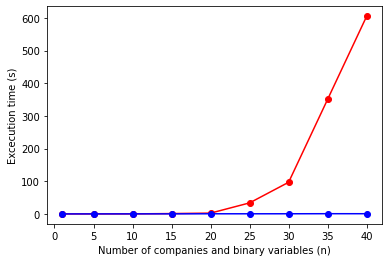

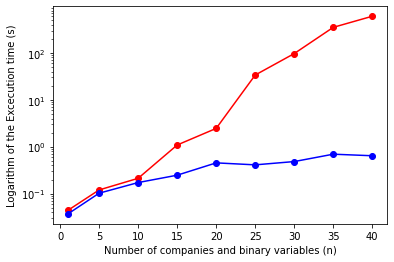

In [ ]:
import matplotlib.pyplot as plt
import pylab

plt.plot(n_comp, time_binary, 'o-r',color='red')
plt.plot(n_comp,time_cont,'o-r',color='blue')
plt.ylabel('Excecution time (s)')
plt.xlabel('Number of companies and binary variables (n)')
plt.show()

plt.semilogy(n_comp, time_binary, 'o-r',color='red')
plt.semilogy(n_comp,time_cont,'o-r',color='blue')
plt.ylabel('Logarithm of the Excecution time (s)')
plt.xlabel('Number of companies and binary variables (n)')
plt.show()


From the graphs, it is clear that while the continuous problem (blue) increases linearly the excecution time, the binary problem (red) is exponential. Also, there is a virtual limit, where the algorithm does not find a sollution in reasonable time.

This should be taken into consideration when designing a binary problem, as for this particular case, the maximum number is set arround 50 binary variables, which is not an extremely large number.

g) For the integer problem in d), solve several instances with the same data, using (10 to 20) different values for one of the parameters in the model (choose
a parameter you think may provide insights for the interpretation of the different solution values). Collect the resulting optimal values of the objective function, print and plot them. Comment on these values.
________________________________________________________________________________

The parameter that will be studied in this part of the assignment is the maximum amount of times that one advertisment can be shown to one client.

In the original problem:

$x_{kij}\leq 14   \forall k,i,j\ $

Which means that every client can watch two times a day the same advertisment as a maximum.

But this value could be greater, meaning that the most valuables advertisment could be shown more to the clients. It will investigated how much changes the revenue when that parameter changes:

$x_{kij}\leq V   \forall k,i,j\ $

In [ ]:
n = 10                                                                          #Reduce the number of companies in this excercise (30 is too large to try many times)
xp = np.random.normal(loc=0.05, scale = 0.025, size=K*m*n)
p={}                                                                            #Price for publicity at every k,i,j
w=0
for k in range(K):
  for i in range(m):
    for j in range(n):
      p[(k+1,i+1,j+1)] = xp[w]
      if p[(k+1,i+1,j+1)]<0:
        p[(k+1,i+1,j+1)] = 0
      w+=1

xs = np.random.normal(loc=20000000,scale=500000,size = n)                       #Maximum amount of money each company is willing to pay weekly
S={}
for j in range(n):
 S[j+1]=max(0,xs[j])

In [ ]:
from pyomo.environ import value

constraint_lst = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]         #V list for varying the condition

for T in constraint_lst:

  mod_binary = pyo.ConcreteModel(name="the_tree_binary")
  mod_binary.k = pyo.Param(within=pyo.NonNegativeIntegers,initialize=K)
  mod_binary.m = pyo.Param(within=pyo.NonNegativeIntegers,initialize=m)
  mod_binary.n = pyo.Param(within=pyo.NonNegativeIntegers,initialize=n)

  mod_binary.K = pyo.RangeSet(1,mod_binary.k)                                   #Number of personalities
  mod_binary.I = pyo.RangeSet(1,mod_binary.m)                                   #Number of tpyes of publicities
  mod_binary.J = pyo.RangeSet(1,mod_binary.n)                                   #Number of companies interested in publicity

  mod_binary.P = pyo.Param(mod_binary.K,mod_binary.I, mod_binary.J,initialize=p)#Price for every publicity
  mod_binary.S = pyo.Param(mod_binary.J,initialize=S)                           #Maximum income recibed by every company
  mod_binary.N = pyo.Param(mod_binary.K,initialize=N)                           #Available money per company
  mod_binary.Q = pyo.Param(mod_binary.K,initialize=q)

  # Defining the variables x_k,i,j
  mod_binary.X = pyo.Var(mod_binary.K,mod_binary.I,mod_binary.J, domain=pyo.NonNegativeReals)

  mod_binary.OBJ = pyo.Objective(rule=obj_expression,sense = pyo.maximize)
  mod_binary.S_Constraint = pyo.Constraint(mod_binary.J, rule=S_constraint_rule)
  mod_binary.N_Constraint = pyo.Constraint(mod_binary.K, rule=N_constraint_rule)


  import math
  M = 9E+9
  mod_binary.h = pyo.Param(within=pyo.NonNegativeIntegers,initialize=math.floor(n/2))
  mod_binary.H = pyo.RangeSet(1,mod_binary.h)                                   #Range for half of the companies

  # Defining the variables y_j (binaries)
  mod_binary.Y = pyo.Var(mod_binary.J, domain=pyo.Binary)
  mod_binary.Y_Constraint = pyo.Constraint(mod_binary.H, rule=Binary_constraint_rule)
  mod_binary.M_Constraint = pyo.Constraint(mod_binary.J, rule=M_constraint_rule)

  #Not show to much every publicity:
  def T_constraint_rule(mod_binary,k,i,j):
     return mod_binary.X[k,i,j] <= T
  mod_binary.T_Constraint = pyo.Constraint(mod_binary.K,mod_binary.I,mod_binary.J, rule=T_constraint_rule)

  results = opt.solve(mod_binary)
  obj_val = int(value(mod_binary.OBJ))
  print("Objective function: ", obj_val, ". For {} value of maximum apearances of any advertisment weekly.".format(T))


Objective function:  0 . For 0 value of maximum apearances of any advertisment weekly.
Objective function:  99355210 . For 1 value of maximum apearances of any advertisment weekly.
Objective function:  99355210 . For 2 value of maximum apearances of any advertisment weekly.
Objective function:  99355210 . For 3 value of maximum apearances of any advertisment weekly.
Objective function:  99355210 . For 4 value of maximum apearances of any advertisment weekly.
Objective function:  99355210 . For 5 value of maximum apearances of any advertisment weekly.
Objective function:  99355210 . For 6 value of maximum apearances of any advertisment weekly.
Objective function:  99355210 . For 7 value of maximum apearances of any advertisment weekly.
Objective function:  99355210 . For 8 value of maximum apearances of any advertisment weekly.
Objective function:  99355210 . For 9 value of maximum apearances of any advertisment weekly.
Objective function:  99355210 . For 10 value of maximum apearances 

The parameter that has been tested, is the maximum times that an advertisment can be shown to a particular client in a week. The default parameter was setted as 14 for the initial problem. Also, the number of companies had been reduced to 10 in order to reduce excecution time for the recurrent problem.

Suppresingly, the objective function does not change anything with the parameter moovement. That could seem to be a problem in the model setup, but actually this is due to the large number of advertisments and companies, that has been generated randomly with the normal distribution. When generating random prices for every advertisment, the number of 1000 variables (10x10x10) make more high price values than the advertisment that can be shown.

The conclusion for this experiment, implies that the initial parameter of 14, does not restrict the revenues for the platform. It seems obvious, that the correct action is to reduce that number (maybe 4-7) in order to aquire different publicities and not bother the clients with the same advertises.